**BPL SOCCER PREDICTIVE BOT**

In [1]:
#importing all the libraries
import pandas as pd 
import xgboost as xgb
import numpy as np
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.metrics import classification_report
from scipy import io
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import voting_classifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier



Using TensorFlow backend.


**Introduction to XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. XGBoost is recognized for its speed and performance

Documentation:https://xgboost.readthedocs.io/en/latest/ 

https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

**Note that my dataset "Premier League Stats" is updated weekly at :**
http://www.football-data.co.uk/englandm.php

In [2]:
df = pd.read_csv('Premier League Stats.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 62 columns):
Div         304 non-null object
Date        304 non-null object
HomeTeam    304 non-null object
AwayTeam    304 non-null object
FTHG        304 non-null int64
FTAG        304 non-null int64
FTR         304 non-null object
HTHG        304 non-null int64
HTAG        304 non-null int64
HTR         304 non-null object
Referee     304 non-null object
HS          304 non-null int64
AS          304 non-null int64
HST         304 non-null int64
AST         304 non-null int64
HF          304 non-null int64
AF          304 non-null int64
HC          304 non-null int64
AC          304 non-null int64
HY          304 non-null int64
AY          304 non-null int64
HR          304 non-null int64
AR          304 non-null int64
B365H       304 non-null float64
B365D       304 non-null float64
B365A       304 non-null float64
BWH         304 non-null float64
BWD         304 non-null float64
BWA       

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


**Data Cleaning**


In [3]:
#Getting rid of all betting data from websites sur as Bet365, Betfair, etc.
desired_columns=['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']
BPLData = df[desired_columns]
print(BPLData.head(10))
#print(BPLData.tail())
print(BPLData.shape)
#df.drop(['Div','Date','Referee','B365H','B365D', 'B365A', 'BWH', 'BWD','BWA','IWH','IWD','IWA','PSH', 'PSD', 'PSA','WHH','WHD','WHA','VCH','VCD','VCA','Bb1X2','BbMxH','BbAvH','BbMxD','BbAvD','BbMxA','BbAvA','BbOU','BbMx>2.5','BbAv>2.5','BbMx<2.5','BbAv<2.5','BbAH','bAHh','BbMxAHH','BbAvAHH','BbMxAHA','BbAvAHA','PSCH','PSCD','PSCA'], axis=1, inplace=True)

#Removed Division (useless), Data, Referee, and all betting data.

       HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  AS  HST  \
0    Man United       Leicester     2     1   H     1     0   H   8  13    6   
1   Bournemouth         Cardiff     2     0   H     1     0   H  12  10    4   
2        Fulham  Crystal Palace     0     2   A     0     1   A  15  10    6   
3  Huddersfield         Chelsea     0     3   A     0     2   A   6  13    1   
4     Newcastle       Tottenham     1     2   A     1     2   A  15  15    2   
5       Watford        Brighton     2     0   H     1     0   H  19   6    5   
6        Wolves         Everton     2     2   D     1     1   D  11   6    4   
7       Arsenal        Man City     0     2   A     0     1   A   9  17    3   
8     Liverpool        West Ham     4     0   H     2     0   H  18   5    8   
9   Southampton         Burnley     0     0   D     0     0   D  18  16    3   

   AST  HF  AF  HC  AC  HY  AY  HR  AR  
0    4  11   8   2   5   2   1   0   0  
1    1  11   9   7   4   1   1   0   

**Data Exploration** 

20 features
304 matches 
          AwayTeam  HomeTeam
0          Arsenal        14
1      Bournemouth        15
2         Brighton        15
3          Burnley        16
4          Cardiff        14
5          Chelsea        15
6   Crystal Palace        15
7          Everton        15
8           Fulham        16
9     Huddersfield        15
10       Leicester        16
11       Liverpool        16
12        Man City        14
13      Man United        16
14       Newcastle        15
15     Southampton        15
16       Tottenham        16
17         Watford        16
18        West Ham        15
19          Wolves        15


C:\Users\Mlej\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


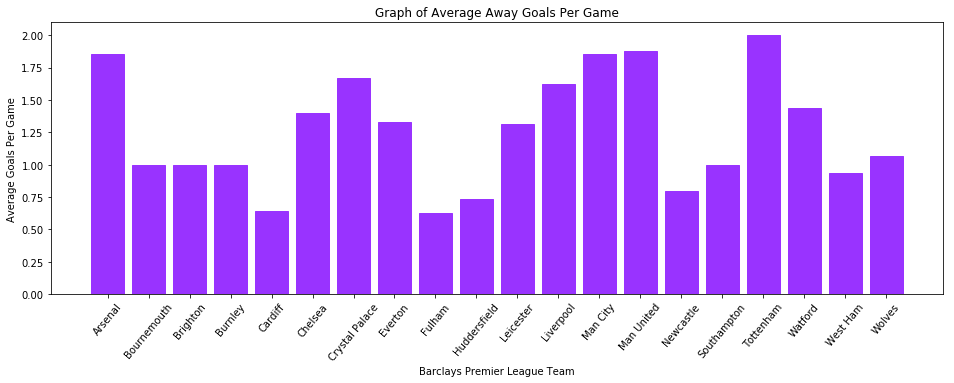

In [4]:
#Inspecting our dataset to find interesting insights 

n_features = BPLData.shape[1] #gives the number of features .shape[1] gives the number of columns (number of features)
n_matches = BPLData.shape[0] #gives the number of matches .shape[0] gives the number of sample in the dataset
print(str(n_features) + ' features')
print(str(n_matches) + ' matches ')

total_home_goal_per_team = BPLData.groupby('HomeTeam').FTHG.sum().reset_index()
#print(total_home_goal_per_team)#we can clearly see that Home teams score more goals than away teams on average

total_away_goal_per_team = BPLData.groupby('AwayTeam').FTAG.sum().reset_index()
#print(total_away_goal_per_team)

total_goal_conceded_per_home_team = BPLData.groupby('HomeTeam').FTAG.sum().reset_index()
#print(total_goal_conceded_per_home_team)

total_goal_conceded_per_away_team = BPLData.groupby('AwayTeam').FTHG.sum().reset_index()
#print(total_goal_conceded_per_away_team)

#Let's find the average home and away goals scored by each team
#First we have to find how many home and away game each team played ***Considering 
numberOfHomeGamesPerTeam = BPLData.groupby('HomeTeam').AwayTeam.count().reset_index()
#print(numberOfHomeGamesPerTeam)
#numberOfHomeGamesPerTeam.info()
numberOfAwayGamesPerTeam = BPLData.groupby('AwayTeam').HomeTeam.count().reset_index()
print(numberOfAwayGamesPerTeam)


#geting a list of the teams
arrayOfTeamsInOrder = BPLData.HomeTeam.sort_values().unique()
listOfTeamsInOrder = list(arrayOfTeamsInOrder)
#print(listOfTeamsInOrder)

#We divide by the number of home/away goals by the number of home/away games to find the average of 
total_home_goal_per_team['AverageHomeGoalsPerGame'] = (total_home_goal_per_team['FTHG']/numberOfHomeGamesPerTeam['AwayTeam'])
#print(total_home_goal_per_team)

plt.figure(figsize=(16, 5))
plt.bar(range(len(total_home_goal_per_team['AverageHomeGoalsPerGame'])),total_home_goal_per_team['AverageHomeGoalsPerGame'], Color='#0000cc')
plt.xlabel('Barclays Premier League Team')
plt.ylabel('Average Goals Per Game')
plt.title('Graph of Average Home Goals Per Game')
ax = plt.subplot(1,1,1)
ax.set_xticks(range(len(total_home_goal_per_team['AverageHomeGoalsPerGame'])))
ax.set_xticklabels(listOfTeamsInOrder, rotation = 50)
#plt.show()
#plt.savefig('AverageGoals.png')
#From the graph we can clearly see the higher performance of the top six teams (Manchester City, Manchester United, Arsenal, Chelsea, Tottenham, Liverpool)

total_away_goal_per_team['AverageAwayGoalsPerGame'] = (total_away_goal_per_team['FTAG']/numberOfAwayGamesPerTeam['HomeTeam'])
#print(total_away_goal_per_team)
plt.close('all')
plt.figure(figsize=(16, 5))
plt.bar(range(len(total_away_goal_per_team['AverageAwayGoalsPerGame'])),total_away_goal_per_team['AverageAwayGoalsPerGame'],Color='#9933ff')
plt.xlabel('Barclays Premier League Team')
plt.ylabel('Average Goals Per Game')
plt.title('Graph of Average Away Goals Per Game')
ax = plt.subplot(1,1,1)
ax.set_xticks(range(len(total_home_goal_per_team['AverageHomeGoalsPerGame'])))
ax.set_xticklabels(listOfTeamsInOrder, rotation = 50)
#plt.show()


#percentage of Home wins this season to see if home team advantage is true 
homeTeamStats = BPLData.groupby('FTR').HomeTeam.count().reset_index()
#print(homeTeamStats)  #We can clearly see that there's a higher amount of H (represents HomeTeam wins) than A (represents Away team), therefore it confirms our hypothesis that Home Team has a higher winning chance
#print(len(BPLData[BPLData.FTR == 'H']))

#Calculating Home Win Percentage
homeWinRate = (len(BPLData[BPLData.FTR == 'H'])/n_matches ) * 100
#print('Home Team Win Rate: ' + str(homeWinRate)) #Home team has a 47.4% winning rate compared to 33.2% from the Away team

awayWinRate = (len(BPLData[BPLData.FTR == 'A'])/n_matches ) * 100
#print('Away Team Win Rate: ' + str(awayWinRate))

#average goals by home team (without considering any particular team)
totalHomeGoals = BPLData.FTHG.sum()
averageHomeTeamGoal = float(totalHomeGoals) / n_matches 
#print("Average number of home goals :", averageHomeTeamGoal) #We can clearly see from this print statement that on average the home team scores more than the away team.

#average goals by away team (without considering any particular team)
totalAwayGoals = BPLData.FTAG.sum()
averageAwayTeamGoal = float(totalAwayGoals) / n_matches 
#print("Average number of away goals :", averageAwayTeamGoal)

#Inspecting every game of a single team, displaying every Man City games...
df = BPLData[(BPLData['HomeTeam'] == 'Man City') | (BPLData['AwayTeam'] == 'Man City')]
ManCity = df.iloc[:]
#print(ManCity.head())

averageHomeGoalsConceded = averageAwayTeamGoal
averageAwayGoalsConceded = averageHomeTeamGoal
#print("Average number of goals conceded at home",avg_home_conceded_16)
#print("Average number of goals conceded away",avg_away_conceded_16)





**Feature Engineering**

In [5]:
print(BPLData.head())
#BPLData.groupby('FTR').HomeTeam.count().reset_index() example 

#print(numberOfHomeGamesPerTeam)
#print(numberOfAwayGamesPerTeam)

#Finding an index for yellow cards for teams at home or away
totalYellowCardPerHomeTeam = BPLData.groupby('HomeTeam').HY.sum().reset_index()
#print(totalYellowCardPerHomeTeam)
totalYellowCardPerAwayTeam = BPLData.groupby('AwayTeam').AY.sum().reset_index()
#print(totalYellowCardPerAwayTeam)

totalYellowCardHome = BPLData['HY'].sum()
#print(totalYellowCardHome)
totalYellowCardAway = BPLData['AY'].sum()
#print(totalYellowCardAway)

averageYellowCardHome = totalYellowCardHome/n_matches
#print(averageYellowCardHome)
averageYellowCardAway = totalYellowCardAway/n_matches
#print(averageYellowCardAway)

yellowCardIndexPerHomeTeam = (totalYellowCardPerHomeTeam.HY/numberOfHomeGamesPerTeam.AwayTeam) / averageYellowCardHome
#print(yellowCardIndexPerHomeTeam)
yellowCardIndexPerAwayTeam = (totalYellowCardPerAwayTeam.AY/numberOfAwayGamesPerTeam.HomeTeam) / averageYellowCardAway
#print(yellowCardIndexPerAwayTeam)

#Finding an index for red cards for teams at home or away

totalRedCardPerHomeTeam = BPLData.groupby('HomeTeam').HR.sum().reset_index()
#print(totalRedCardPerAwayTeam)
totalRedCardPerAwayTeam = BPLData.groupby('AwayTeam').AR.sum().reset_index()
#print(totalRedCardPerAwayTeam)
totalRedCardHome = BPLData.HR.sum()
# print(totalRedCardHome)
totalRedCardAway = BPLData.AR.sum()
# print(totalRedCardAway)
averageRedCardHome = totalRedCardHome / n_matches
#print(averageRedCardHome)
averageRedCardAway = totalRedCardAway / n_matches 
#print(averageRedCardAway)

redCardIndexPerHomeTeam = (totalRedCardPerHomeTeam.HR/numberOfHomeGamesPerTeam.AwayTeam) / averageRedCardHome
#print(redCardIndexPerHomeTeam)
redCardIndexPerAwayTeam = (totalRedCardPerAwayTeam.AR/numberOfAwayGamesPerTeam.HomeTeam) / averageRedCardAway
#print(redCardIndexPerAwayTeam)

#Finding an index for the # of shots on target for teams at home or away

totalShotOnTargetPerHomeTeam = BPLData.groupby('HomeTeam').HST.sum().reset_index()
#print(totalShotOnTargetPerHomeTeam)
totalShotOnTargetPerAwayTeam = BPLData.groupby('AwayTeam').AST.sum().reset_index()
#print(totalShotOnTargetPerAwayTeam)
totalShotOnTargetHome = BPLData.HST.sum()
#print(totalShotOnTargetHome)
totalShotOnTargetAway = BPLData.AST.sum()
#print(totalShotOnTargetAway)

shotOnTargetIndexPerHomeTeam = (totalShotOnTargetPerHomeTeam.HST/numberOfHomeGamesPerTeam.AwayTeam) / (totalShotOnTargetHome/n_matches)
#print(shotOnTargetIndexPerHomeTeam)
shotOnTargetIndexPerAwayTeam = (totalShotOnTargetPerAwayTeam.AST/numberOfAwayGamesPerTeam.HomeTeam) / (totalShotOnTargetAway/n_matches)
#print(shotOnTargetIndexPerAwayTeam)

#Finding an index for the number of fouls 

totalFoulsPerHomeTeam = BPLData.groupby('HomeTeam').HF.sum().reset_index() 
#print(totalFoulsPerHomeTeam)
totalFoulsPerAwayTeam = BPLData.groupby('AwayTeam').AF.sum().reset_index() 
#print(totalFoulsPerAwayTeam)
totalHomeFouls = BPLData.HF.sum()
#print(totalHomeFouls)
totalAwayFouls = BPLData.AF.sum()
#print(totalAwayFouls)
foulIndexPerHomeTeam = (totalFoulsPerHomeTeam.HF/numberOfHomeGamesPerTeam.AwayTeam) / (totalHomeFouls/n_matches)
# print(foulIndexPerHomeTeam)
foulIndexPerAwayTeam = (totalFoulsPerAwayTeam.AF/numberOfAwayGamesPerTeam.HomeTeam) / (totalAwayFouls/n_matches)
# print(foulIndexPerAwayTeam)

#Finding an index for the number of shots 
totalShotsPerHomeTeam = BPLData.groupby('HomeTeam').HS.sum().reset_index()
#print(totalShotsPerHomeTeam)
totalShotsPerAwayTeam = BPLData.groupby('AwayTeam').AS.sum().reset_index()
#print(totalShotsPerAwayTeam)
totalHomeShots = BPLData.HS.sum()
#print(totalHomeShots)
totalAwayShots = BPLData.AS.sum()
#print(totalAwayShots)
shotIndexPerHomeTeam = (totalShotsPerHomeTeam.HS/numberOfHomeGamesPerTeam.AwayTeam) / (totalHomeShots/n_matches)
# print(shotIndexPerHomeTeam)
shotIndexPerAwayTeam = (totalShotsPerAwayTeam.AS/numberOfAwayGamesPerTeam.HomeTeam) / (totalAwayShots/n_matches)
# print(shotIndexPerAwayTeam)

#Finding an index for the number of cornerkicks
totalNumberOfCornerKicksPerHomeTeam = BPLData.groupby('HomeTeam').HC.sum().reset_index()
#print(totalNumberOfCornerKicksPerHomeTeam)
totalNumberOfCornerKicksPerAwayTeam = BPLData.groupby('AwayTeam').AC.sum().reset_index()
#print(totalNumberOfCornerKicksPerAwayTeam)
totalCornerKicksHome = BPLData.HC.sum()
#print(totalCornerKicksHome)
totalCornerKicksAway = BPLData.AC.sum()
#print(totalCornerKicksAway)
cornerKicksIndexPerHomeTeam = (totalNumberOfCornerKicksPerHomeTeam.HC/numberOfHomeGamesPerTeam.AwayTeam) / (totalCornerKicksHome/n_matches)
#print(cornerKicksIndexPerHomeTeam)
cornerKicksIndexPerAwayTeam = (totalNumberOfCornerKicksPerAwayTeam.AC/numberOfAwayGamesPerTeam.HomeTeam) / (totalCornerKicksAway/n_matches)
#print(cornerKicksIndexPerAwayTeam)

#Finding an index of goal efficiency or we can say Conversion Rate (Number of Goals / Number of Shots) VERY IMPORTANT tells us how a team is efficient in front of the goal
totalNumberOfGoalsPerHomeTeam = BPLData.groupby('HomeTeam').FTHG.sum().reset_index()
#print(totalNumberOfGoalsPerHomeTeam)
totalNumberOfGoalsPerAwayTeam = BPLData.groupby('AwayTeam').FTAG.sum().reset_index()
#print(totalNumberOfGoalsPerAwayTeam)
totalNumberOfShotsPerHomeTeam = BPLData.groupby('HomeTeam').HS.sum().reset_index()
#print(totalNumberOfShotsPerHomeTeam)
totalNumberOfShotsPerAwayTeam = BPLData.groupby('AwayTeam').AS.sum().reset_index()
#print(totalNumberOfShotsPerAwayTeam)

homeConversionRate = (totalNumberOfGoalsPerHomeTeam.FTHG/totalNumberOfShotsPerHomeTeam.HS) * 100
#print(homeConversionRate)
awayConversionRate = (totalNumberOfGoalsPerAwayTeam.FTAG/totalNumberOfShotsPerAwayTeam.AS) * 100
#print(awayConversionRate)

       HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  AS  HST  \
0    Man United       Leicester     2     1   H     1     0   H   8  13    6   
1   Bournemouth         Cardiff     2     0   H     1     0   H  12  10    4   
2        Fulham  Crystal Palace     0     2   A     0     1   A  15  10    6   
3  Huddersfield         Chelsea     0     3   A     0     2   A   6  13    1   
4     Newcastle       Tottenham     1     2   A     1     2   A  15  15    2   

   AST  HF  AF  HC  AC  HY  AY  HR  AR  
0    4  11   8   2   5   2   1   0   0  
1    1  11   9   7   4   1   1   0   0  
2    9   9  11   5   5   1   2   0   0  
3    4   9   8   2   5   2   1   0   0  
4    5  11  12   3   5   2   2   0   0  


**Graph that demonstrate home advantage**

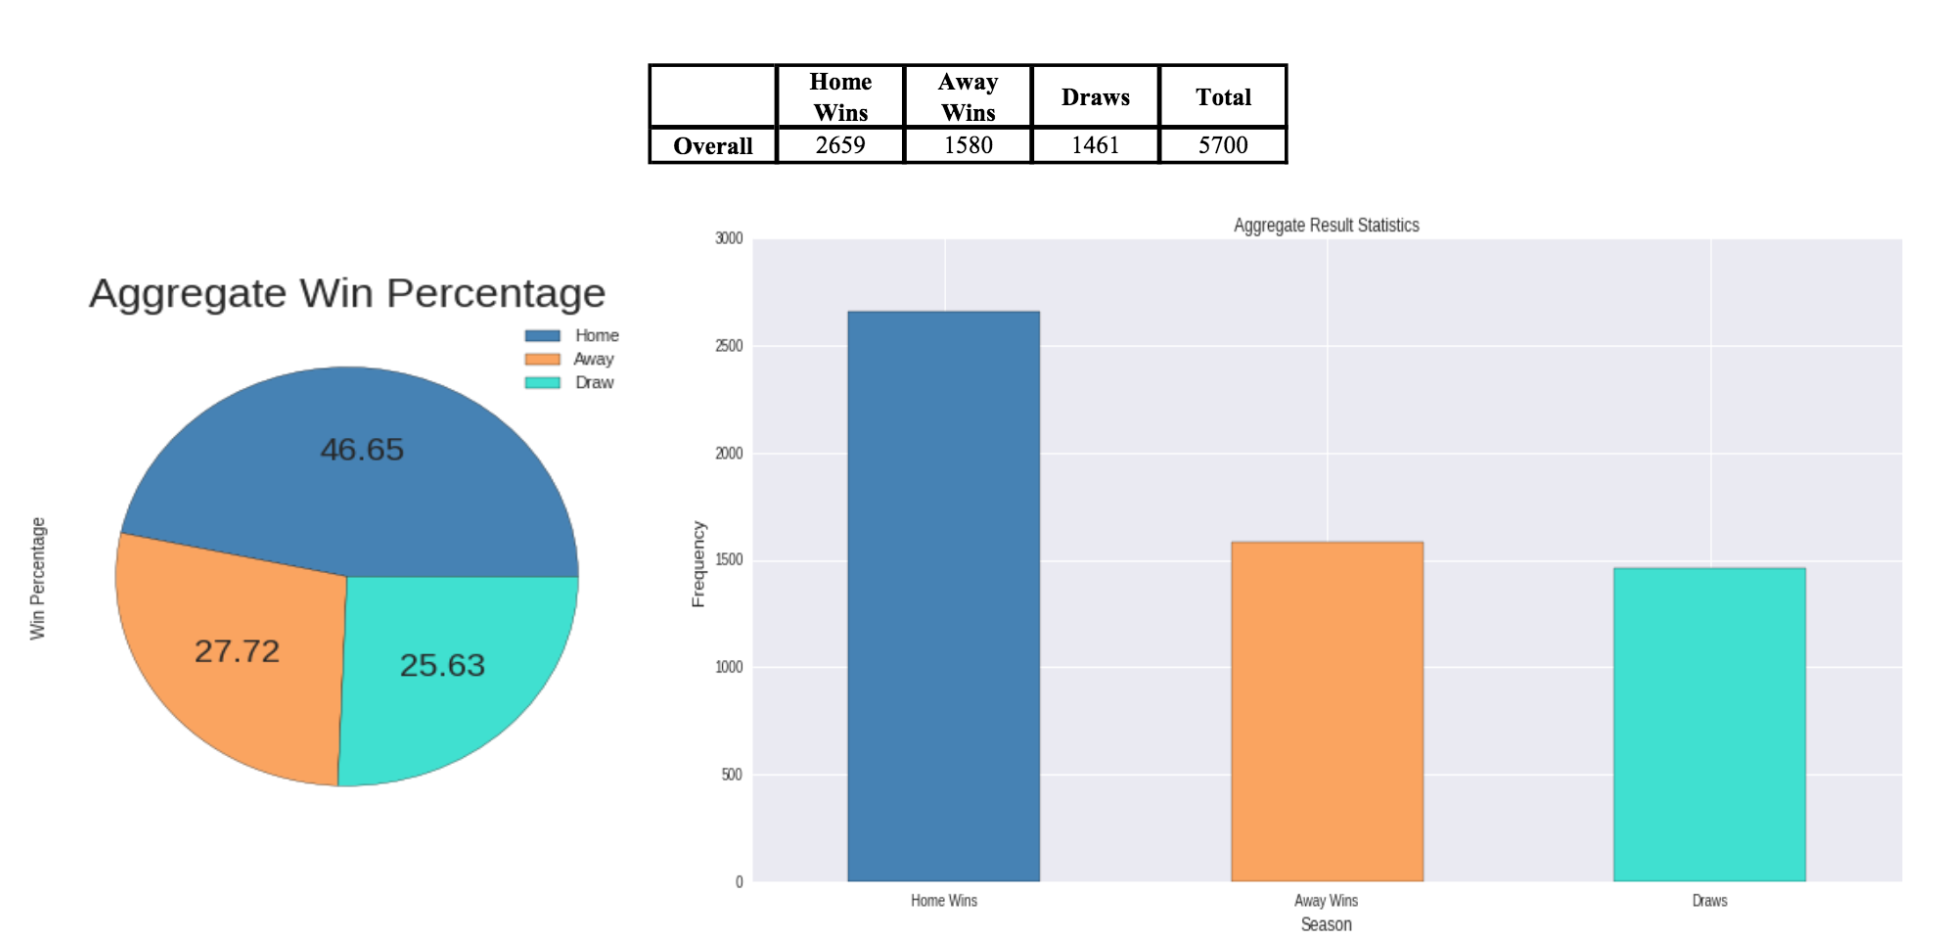

 


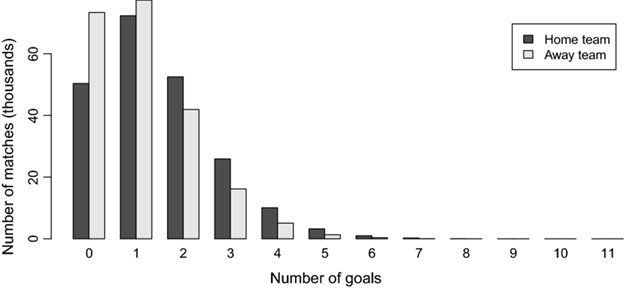

from : https://link.springer.com/article/10.1007/s10994-018-5741-1


The number of matches per number of goals scored by the home (dark grey) and away team (light grey)
Figure 2 shows the number of matches per number of goals scored by the home (dark grey) and away (light grey) teams. Home teams appear to score more goals than away teams, with home teams having consistently higher frequencies for two or more goals and away teams having higher frequencies for no goal and one goal. Overall, home teams scored 304,918 goals over the whole data set, whereas away teams scored 228,293 goals. In Section 1 of the Supplementary Material, the trend shown in Fig. 2 is also found to be present within each country, pointing towards the existence of a home advantage.


From this historical statistic, we can also affirm that home teams definitely have an advantage as we can think of the following reasons:

- Football is a team sport, a cheering crowd helps morale
- Familarity with pitch and weather conditions helps
- No need to travel (less fatigue)


**Data preprocessing**

This is a supervised learning problem. We have one target variable which is FTR (stands for full-time result). We want to predict FTR given all the features in the dataset. We also want to standarize our dataset and put it on the same scale (mean=0, variance=1) 

We want to combine or extract certain columns of this dataset to find the final features that we are going to work with.

features:
- last 5 games form (in the form of an integer 1.0 representing a Win, 0.5 Draw and 0.0 Loss)
- Attacking Score (float, based on the number of chances created per game, the number of goals scored and more...)
- Defending Score (float, based on the number of goals conceded per game, fouls committed, yellow and red cards conceded and more..)

To do list:
- find a way to turn free kicks and corner kicks into goal scoring opportunities (how to consider them)?
- append last 5 games results to model
- Hyperparameter tuning to increase the performance of our model.

In [6]:
#Creating new DataFrame that displays characteristics per team with the following features: Home Goals Score, Away Goals Score, Home/Away Attack Strength, Home Goals Conceded, Away Goals Conceded, Home/Away Defensive Strength
columns = ['Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS','HTYCI','ATYCI','HTRCI',
           'ATRCI','HTSOTI','ATSOTI','HTFI','ATFI','HTSI','ATSI','HTCKI','ATCKI','HTCR','ATCR']
season19 = pd.DataFrame(columns=columns)
season19.Team = listOfTeamsInOrder #list of the teams in order 
season19.HGS = total_home_goal_per_team.FTHG #Total home goal scored per team
season19.AGS = total_away_goal_per_team.FTAG #Total Away goal scored per team 
season19.HAS = (season19.HGS/numberOfHomeGamesPerTeam.AwayTeam) / averageHomeTeamGoal #Home team attacking strength
season19.AAS = (season19.AGS/numberOfAwayGamesPerTeam.HomeTeam) / averageAwayTeamGoal #Away team attacking strenth
season19.HGC = total_goal_conceded_per_home_team.FTAG #Total home goal conceded per team 
season19.AGC = total_goal_conceded_per_away_team.FTHG #Total away goal conceded per team 
season19.HDS = (season19.HGC/numberOfHomeGamesPerTeam.AwayTeam) / averageHomeGoalsConceded #Home team defensive strength
season19.ADS = (season19.AGC/numberOfAwayGamesPerTeam.HomeTeam) / averageAwayGoalsConceded #Away team defensive strength 
season19.HTYCI = yellowCardIndexPerHomeTeam
season19.ATYCI = yellowCardIndexPerAwayTeam
season19.HTRCI = redCardIndexPerHomeTeam
season19.ATRCI = redCardIndexPerAwayTeam
season19.HTSOTI = shotOnTargetIndexPerHomeTeam
season19.ATSOTI = shotOnTargetIndexPerAwayTeam
season19.HTFI = foulIndexPerHomeTeam
season19.ATFI = foulIndexPerAwayTeam
season19.HTSI = shotIndexPerHomeTeam
season19.ATSI = shotIndexPerAwayTeam
season19.HTCKI = cornerKicksIndexPerHomeTeam
season19.ATCKI = cornerKicksIndexPerAwayTeam
season19.HTCR = homeConversionRate
season19.ATCR = awayConversionRate
print(season19)

#Important note: The higher a team's HAS/AAS score is, the better they are at scoring goals
#In the other side: The lower a team's HDS/ADS is, the better they are at not conceding goals, which means the stronger they are in defense, the lower their HDS/ADS will be.


              Team  HGS  AGS       HAS       AAS  HGC  AGC       HDS  \
0          Arsenal   37   26  1.455487  1.474077   12   27  0.595300   
1      Bournemouth   28   15  1.101449  0.793734   21   35  1.041775   
2         Brighton   17   15  0.764271  0.793734   15   27  0.850429   
3          Burnley   19   16  0.797239  0.793734   28   31  1.481636   
4          Cardiff   18    9  0.708075  0.510257   31   26  1.537859   
5          Chelsea   29   21  1.216839  1.111227   10   23  0.529156   
6   Crystal Palace   11   25  0.461560  1.322889   17   24  0.899565   
7          Everton   23   20  0.904762  1.058312   21   21  1.041775   
8           Fulham   19   10  0.797239  0.496084   30   40  1.587467   
9     Huddersfield    7   11  0.275362  0.582071   24   33  1.190601   
10       Leicester   19   21  0.797239  1.041775   19   24  1.005396   
11       Liverpool   44   26  1.846239  1.289817    9    9  0.476240   
12        Man City   53   26  2.084886  1.474077   12    9  0.59

In [7]:
#dataframe with engineered features 

bot = BPLData[['HomeTeam', 'AwayTeam', 'FTR']]

HAS = []
HDS = []
AAS = []
ADS = []
HTYCI = []
ATYCI = []
HTRCI = []
ATRCI = []
HTSOTI = []
ATSOTI = []
HTFI = []
ATFI = []
HTSI = []
ATSI = []
HTCKI = []
ATCKI = []
HTCR = []
ATCR = []


for index, row in bot.iterrows(): #Iterate over DataFrame rows as (index, Series) pairs. 
    HAS.append(season19[season19.Team == row['HomeTeam']]['HAS'].values[0])
    HDS.append(season19[season19.Team == row['HomeTeam']]['HDS'].values[0])
    AAS.append(season19[season19.Team == row['AwayTeam']]['AAS'].values[0])
    ADS.append(season19[season19.Team == row['AwayTeam']]['ADS'].values[0])
    HTYCI.append(season19[season19.Team==row['HomeTeam']]['HTYCI'].values[0])
    ATYCI.append(season19[season19.Team==row['AwayTeam']]['ATYCI'].values[0])
    HTRCI.append(season19[season19.Team==row['HomeTeam']]['HTRCI'].values[0])
    ATRCI.append(season19[season19.Team==row['AwayTeam']]['ATRCI'].values[0])
    HTSOTI.append(season19[season19.Team==row['HomeTeam']]['HTSOTI'].values[0])
    ATSOTI.append(season19[season19.Team==row['AwayTeam']]['ATSOTI'].values[0])
    HTFI.append(season19[season19.Team==row['HomeTeam']]['HTFI'].values[0])
    ATFI.append(season19[season19.Team==row['AwayTeam']]['ATFI'].values[0])
    HTSI.append(season19[season19.Team==row['HomeTeam']]['HTSI'].values[0])
    ATSI.append(season19[season19.Team==row['AwayTeam']]['ATSI'].values[0])
    HTCKI.append(season19[season19.Team==row['HomeTeam']]['HTCKI'].values[0])
    ATCKI.append(season19[season19.Team==row['AwayTeam']]['ATCKI'].values[0])
    HTCR.append(season19[season19.Team==row['HomeTeam']]['HTCR'].values[0])
    ATCR.append(season19[season19.Team==row['AwayTeam']]['ATCR'].values[0])
    
bot['HAS'] =HAS
bot['HDS']=HDS
bot['HTYCI']=HTYCI
bot['HTRCI']=HTRCI
bot['HTSOTI']=HTSOTI
bot['HTFI']=HTFI
bot['HTSI']=HTSI
bot['HTCKI']=HTCKI
bot['HTCR']=HTCR
bot['AAS']=AAS
bot['ADS']=ADS
bot['ATYCI']=ATYCI
bot['ATRCI']=ATRCI
bot['ATSOTI']=ATSOTI
bot['ATFI']=ATFI
bot['ATSI']=ATSI
bot['ATCKI']=ATCKI
bot['ATCR']=ATCR

print(bot)

C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

           HomeTeam        AwayTeam FTR       HAS       HDS     HTYCI  \
0        Man United       Leicester   H  1.258799  1.020515  1.007836   
1       Bournemouth         Cardiff   H  1.101449  1.041775  1.282700   
2            Fulham  Crystal Palace   A  0.797239  1.587467  1.239944   
3      Huddersfield         Chelsea   A  0.275362  1.190601  0.841772   
4         Newcastle       Tottenham   A  0.747412  0.992167  0.921941   
5           Watford        Brighton   H  0.854185  1.077210  1.099458   
6            Wolves         Everton   D  0.923119  1.005396  1.239944   
7           Arsenal        Man City   A  1.455487  0.595300  1.162447   
8         Liverpool        West Ham   H  1.846239  0.476240  0.555837   
9       Southampton         Burnley   D  0.797239  1.164143  1.453727   
10          Cardiff       Newcastle   D  0.708075  1.537859  1.202532   
11          Chelsea         Arsenal   H  1.216839  0.529156  0.684107   
12          Everton     Southampton   H  0.904762  

C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#final dataframe 
predictiveBot = BPLData[['HomeTeam','AwayTeam','FTR','HST','AST','HF','AF','HC','AC','HR','AR']]


HAS = []
HDS = []
AAS = []
ADS = []

for index, row in predictiveBot.iterrows(): #Iterate over DataFrame rows as (index, Series) pairs. 
    HAS.append(season19[season19.Team == row['HomeTeam']]['HAS'].values[0])
    HDS.append(season19[season19.Team == row['HomeTeam']]['HDS'].values[0])
    AAS.append(season19[season19.Team == row['AwayTeam']]['AAS'].values[0])
    ADS.append(season19[season19.Team == row['AwayTeam']]['ADS'].values[0])
    
predictiveBot['HAS'] = HAS
predictiveBot['HDS'] = HDS
predictiveBot['AAS'] = AAS
predictiveBot['ADS'] = ADS

print(predictiveBot.head(10))
# FTR : Full Time Result
# HST : Home Shots on Target (goal opportunity)
# AST : Away Shots on Target (goal opportunity)
# HF : Home Faults
# AF : Away Faults
# HC : Home corners (goal opportunity)
# AC : Away corners (goal opportunity)
# HR : Home Red Card (decided to ignore Yellow cards, because it only has an impact on the game if it results to a red card)
# AR : Away Red Card
# HAS : Home Attacking Strength
# HDS : Home Defensive Strength
# AAS : Away Attacking Strength
# ADS : Away Defensive Strength



       HomeTeam        AwayTeam FTR  HST  AST  HF  AF  HC  AC  HR  AR  \
0    Man United       Leicester   H    6    4  11   8   2   5   0   0   
1   Bournemouth         Cardiff   H    4    1  11   9   7   4   0   0   
2        Fulham  Crystal Palace   A    6    9   9  11   5   5   0   0   
3  Huddersfield         Chelsea   A    1    4   9   8   2   5   0   0   
4     Newcastle       Tottenham   A    2    5  11  12   3   5   0   0   
5       Watford        Brighton   H    5    0  10  16   8   2   0   0   
6        Wolves         Everton   D    4    5   8   7   3   6   0   1   
7       Arsenal        Man City   A    3    8  11  14   2   9   0   0   
8     Liverpool        West Ham   H    8    2  14   9   5   4   0   0   
9   Southampton         Burnley   D    3    6  10   9   8   5   0   0   

        HAS       HDS       AAS       ADS  
0  1.258799  1.020515  1.041775  0.944099  
1  1.101449  1.041775  0.510257  1.168885  
2  0.797239  1.587467  1.322889  1.007039  
3  0.275362  1.19060

C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mlej\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [43]:
#Transforming H,D,A to integers 
def stringToInteger(str):
    if str.FTR == 'H':
        return 1
    elif str.FTR == 'A':
        return -1
    else:
        return 0
   
bot['Result'] = bot.apply(lambda row : stringToInteger(row), axis = 1)
bot

,HomeTeam,AwayTeam,FTR,HAS,HDS,HTYCI,HTRCI,HTSOTI,HTFI,HTSI,...,AAS,ADS,ATYCI,ATRCI,ATSOTI,ATFI,ATSI,ATCKI,ATCR,Result
0,Man United,Leicester,H,1.258799,1.020515,1.007836,1.447619,1.496005,1.069367,1.097090,...,1.041775,0.944099,0.796190,2.280000,1.102607,0.852449,1.042121,1.219178,11.602210,1
1,Bournemouth,Cardiff,H,1.101449,1.041775,1.282700,1.266667,0.894270,0.911857,0.813970,...,0.510257,1.168885,0.909932,0.868571,0.730506,0.926202,0.875152,0.876712,6.766917,1
2,Fulham,Crystal Palace,A,0.797239,1.587467,1.239944,1.351111,1.064484,1.087077,1.099449,...,1.322889,1.007039,1.158095,0.810667,0.920437,1.056556,0.933495,0.891324,16.447368,-1
3,Huddersfield,Chelsea,A,0.275362,1.190601,0.841772,3.800000,0.609141,1.048934,0.765308,...,1.111227,0.965079,0.849270,0.000000,1.142024,0.896472,1.375677,1.095890,9.375000,-1
4,Newcastle,Tottenham,A,0.747412,0.992167,0.921941,1.266667,0.803547,1.048934,0.968801,...,1.587467,0.747412,1.013333,0.760000,1.166526,1.020537,1.128485,1.082192,16.326531,-1
5,Watford,Brighton,H,0.854185,1.077210,1.099458,1.447619,0.888716,1.137480,0.788691,...,0.793734,1.132919,0.965079,1.621333,0.818167,1.267867,0.859798,0.847489,10.714286,1
6,Wolves,Everton,D,0.923119,1.005396,1.239944,0.000000,0.953888,1.087077,0.972045,...,1.058312,0.881159,1.042286,3.242667,1.056798,1.037346,0.933495,1.022831,13.157895,0
7,Arsenal,Man City,A,1.455487,0.595300,1.162447,0.000000,1.023874,1.090652,0.959953,...,1.474077,0.404614,0.992653,0.868571,1.424486,0.809569,1.316017,1.737769,13.000000,-1
8,Liverpool,West Ham,H,1.846239,0.476240,0.555837,1.351111,1.437744,0.832790,1.283477,...,0.740818,0.965079,1.042286,0.810667,0.801121,0.870858,0.841374,0.803653,10.218978,1
9,Southampton,Burnley,D,0.797239,1.164143,1.453727,2.702222,0.995362,1.157005,0.953170,...,0.793734,1.219462,1.302857,0.760000,0.671152,0.876461,0.731212,0.712329,12.598425,0


In [44]:
#Separate into feature set and target variable
#Target is 'Result' (1 == H which means home team wins, 0 == D means Draw,-1 == A means Away team wins)

Y = bot['Result']
x = bot[['HAS', 'HDS', 'HTYCI', 'HTRCI', 'HTSOTI', 'HTFI', 'HTSI',
        'HTCKI', 'HTCR', 'AAS', 'ADS', 'ATYCI', 'ATRCI', 'ATSOTI', 'ATFI', 'ATSI', 'ATCKI', 'ATCR']]

print(x.shape)
print(Y)

(304, 18)
0      1
1      1
2     -1
3     -1
4     -1
5      1
6      0
7     -1
8      1
9      0
10     0
11     1
12     1
13     1
14     1
15    -1
16     1
17    -1
18     1
19    -1
20     1
21     0
22     0
23     1
24    -1
25     0
26     1
27    -1
28     1
29    -1
      ..
274    1
275   -1
276    1
277    1
278    1
279   -1
280    1
281   -1
282    1
283    0
284    1
285    1
286    0
287   -1
288    1
289    1
290   -1
291   -1
292    1
293    1
294    1
295    1
296    1
297    0
298    1
299    0
300   -1
301    1
302    1
303   -1
Name: Result, Length: 304, dtype: int64


In [45]:
#Standardising the data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaledData = scaler.fit_transform(x)

print(scaledData)
#print(x)

[[ 0.61468569  0.06659381  0.03186509 ...  0.26692319  0.92540318
   0.02673912]
 [ 0.24095679  0.13560922  1.14959452 ... -0.791168   -0.52053929
  -1.46371166]
 [-0.48158575  1.90700468  0.9757255  ... -0.42144419 -0.45884575
   1.52023099]
 ...
 [ 0.14752457  0.45768112 -0.15442314 ... -0.11009781 -0.33545865
  -1.4303958 ]
 [-0.22620433  0.13560922 -0.48042756 ...  2.38067317  0.40486389
  -0.65978536]
 [-0.48158575  1.90700468  0.9757255  ...  0.74123993  1.44594248
   0.58153299]]


In [65]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encoding my target values 
encoder = LabelEncoder()
encoder.fit(bot.FTR)
encoded_Y = encoder.transform(bot.FTR)

y_one_hot_encoded = np_utils.to_categorical(encoded_Y)
print(y_one_hot_encoded)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1.

In [46]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(scaledData, Y, test_size=0.20, train_size = 0.80)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


LogisticClassifier = LogisticRegression(solver = 'newton-cg', multi_class= 'multinomial', dual = False, C = 0.75, max_iter = 3) 
y_pred = LogisticClassifier.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, y_pred))

(243, 18)
(243,)
(61, 18)
(61,)
0.5737704918032787


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [47]:
#Trying out different models

#Trying Logistic Regression 
LogisticClassifier = LogisticRegression(solver = 'newton-cg', multi_class= 'multinomial', dual = False, C = 0.75, max_iter = 3) 
scores = cross_val_score(LogisticClassifier, scaledData, Y, cv=10, scoring = 'accuracy')
print("LogisticRegression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
y_pred = cross_val_predict(LogisticClassifier, scaledData, Y, cv=10)
conf_mat = confusion_matrix(Y, y_pred)
print(classification_report(Y,y_pred))

clf1 = RandomForestClassifier()
scores = cross_val_score(clf1, scaledData, Y, cv=10, scoring = 'accuracy')
print("Random Forest accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
y_pred1 = cross_val_predict(clf1, scaledData,Y, cv=10)
conf_mat1 = confusion_matrix(Y, y_pred1)

clf3 = LinearSVC()
scores = cross_val_score(clf3, scaledData, Y, cv=10, scoring = 'accuracy')
print("LinearSVC accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
y_pred2 = cross_val_predict(clf3, scaledData, Y, cv=10)
conf_mat2 = confusion_matrix(Y, y_pred2)

#Trying XGBoost
xgBoost = xgb.XGBClassifier()
scores = cross_val_score(xgBoost, scaledData, Y, cv=10, scoring = 'accuracy')
print("XGBoost accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
y_pred3 = cross_val_predict(xgBoost, scaledData, Y, cv=10)
conf_mat3 = confusion_matrix(Y, y_pred3)

#Trying SVM 
svm = SVC(gamma=0.001,C=1, decision_function_shape='ovo')
scores = cross_val_score(svm, scaledData, Y, cv=10)
print("SVC accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
y_pred4 = cross_val_predict(svm, scaledData, Y, cv=10)
conf_mat4 = confusion_matrix(Y, y_pred4)
print(classification_report(Y,y_pred4))

#solver = 'newton-cg', multi_class= 'multinomial'
#gamma='scale', decision_function_shape='ovo'

#Printing confusion matrix:Performance measurement for machine learning classification

print(conf_mat)

print(conf_mat1)

print(conf_mat2)

print(conf_mat3)

print(conf_mat4)





C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iteration

LogisticRegression accuracy: 0.60 (+/- 0.09)
              precision    recall  f1-score   support

          -1       0.60      0.66      0.63       100
           0       0.23      0.05      0.08        58
           1       0.63      0.78      0.70       146

   micro avg       0.60      0.60      0.60       304
   macro avg       0.49      0.50      0.47       304
weighted avg       0.54      0.60      0.56       304



C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

Random Forest accuracy: 0.55 (+/- 0.16)


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the nu

LinearSVC accuracy: 0.61 (+/- 0.12)


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

XGBoost accuracy: 0.58 (+/- 0.12)
SVC accuracy: 0.60 (+/- 0.04)
              precision    recall  f1-score   support

          -1       0.75      0.46      0.57       100
           0       0.00      0.00      0.00        58
           1       0.56      0.94      0.70       146

   micro avg       0.60      0.60      0.60       304
   macro avg       0.44      0.47      0.43       304
weighted avg       0.52      0.60      0.53       304

[[ 66   4  30]
 [ 18   3  37]
 [ 26   6 114]]
[[64 13 23]
 [20 11 27]
 [32 17 97]]
[[ 72   2  26]
 [ 19   2  37]
 [ 33   2 111]]
[[ 65  10  25]
 [ 13  10  35]
 [ 29  15 102]]
[[ 46   0  54]
 [  6   0  52]
 [  9   0 137]]


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
#Hyperparameter Tuning for logistic regression...
#Using KFold cross validation technique 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=10)
dual = [False]
max_iter = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,110,120,130,140,145,170,200]
C = [0.0001,0.01,0.1, 0.5, 0.75,1.0,2,3,4,5,6,7,8,9,10,15,20,50,100]
#solver = ['newton-cg','lbfgs','liblinear','sag', 'saga']

param_grid = dict(max_iter = max_iter,C=C,dual = dual)

grid = GridSearchCV(estimator=LogisticClassifier, param_grid=param_grid, cv = 10, n_jobs = -1)

grid_result = grid.fit(scaledData,Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Best: 0.625000 using {'C': 0.1, 'dual': False, 'max_iter': 2}


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [49]:
Cs = [0.001, 0.01, 0.1, 1, 2,3,5,10,12,15,17,20]
gammas = [0.001, 0.01, 0.1, 1, 'scale']
param_grid = dict(C=Cs,gamma=gammas)
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs = -1)
grid_search.fit(scaledData, Y)
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.641447 using {'C': 3, 'gamma': 0.001}


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
def svc_param_selection(X, y, nfolds):
   
    Cs = [0.0001,0.001, 0.01, 0.1, 1, 10]
    gammas = [0.0001,0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

print(svc_param_selection(X_train, y_train, 10))


{'C': 10, 'gamma': 0.001}


C:\Users\Mlej\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [69]:
seed =7
np.random.seed(seed)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from keras.layers.core import Activation 

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=18, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))  
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 10,verbose = 0,mode = 'auto')
    checkpointer = ModelCheckpoint(filepath = "best_weights.hdf5", verbose = 0,save_best_only=True)
                            
    return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, scaledData, y_one_hot_encoded, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=18, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))  
    model.add(Dense(3, activation='softmax'))

                            
    return model
    # Compile model
    
model = baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(scaledData, y_one_hot_encoded, epochs=100, batch_size=10)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 10,verbose = 0,mode = 'auto')
checkpointer = ModelCheckpoint(filepath = "best_weights1.hdf5", verbose = 0,save_best_only=True)

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, scaledData, y_one_hot_encoded, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

y_pred = model.predict(X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))

In [ ]:
###NEED TO ONE HOT ENCODE DATA 
model = create_model()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train_enc, epochs=20, batch_size=BATCH_SIZE)
y_pred = predict(model, X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))